<a id="im"></a>
# <center>Custom Dataset \(Training, Testing, Confusion Matrix and AUC Curve\)</center>

Found 3109 images belonging to 14 classes.
Found 1333 images belonging to 14 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/26


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.0876 - loss: 3.5438 - val_accuracy: 0.1598 - val_loss: 4.0961
Epoch 2/26
49/49 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.0922 - loss: 3.4455 - val_accuracy: 0.0630 - val_loss: 5.4916
Epoch 3/26
49/49 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.0989 - loss: 3.4167 - val_accuracy: 0.0863 - val_loss: 6.8944
Epoch 4/26
49/49 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.1153 - loss: 3.2495 - val_accuracy: 0.0795 - val_loss: 7.9630
Epoch 5/26
49/49 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.1244 - loss: 3.2536 - val_accuracy: 0.0518 - val_loss: 8.7159
Epoch 6/26
49/49 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.1266 - loss: 3.1256 - val_accuracy: 0.0630 - val_loss: 8.6262
Epoch 7/26
49/49 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.1422 - loss: 3.0513 - val_accuracy: 0.1110 - val_loss: 7.8771
Epoch 8/26
49/49 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.1452 - loss: 2.9693 - val_accuracy: 0.1395 - val_loss: 6.

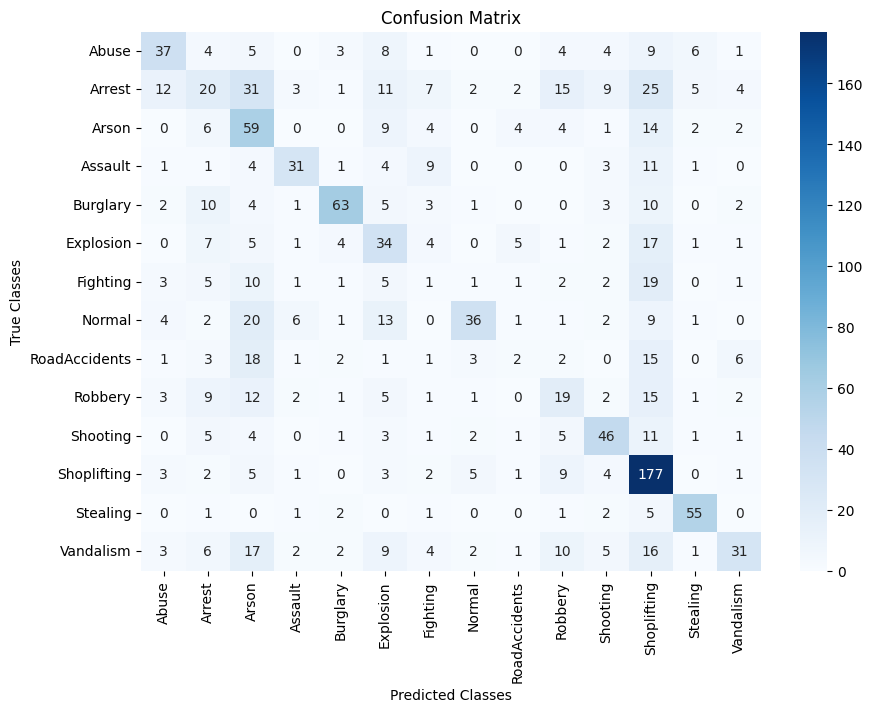

ROC AUC score: 0.8363467100256511


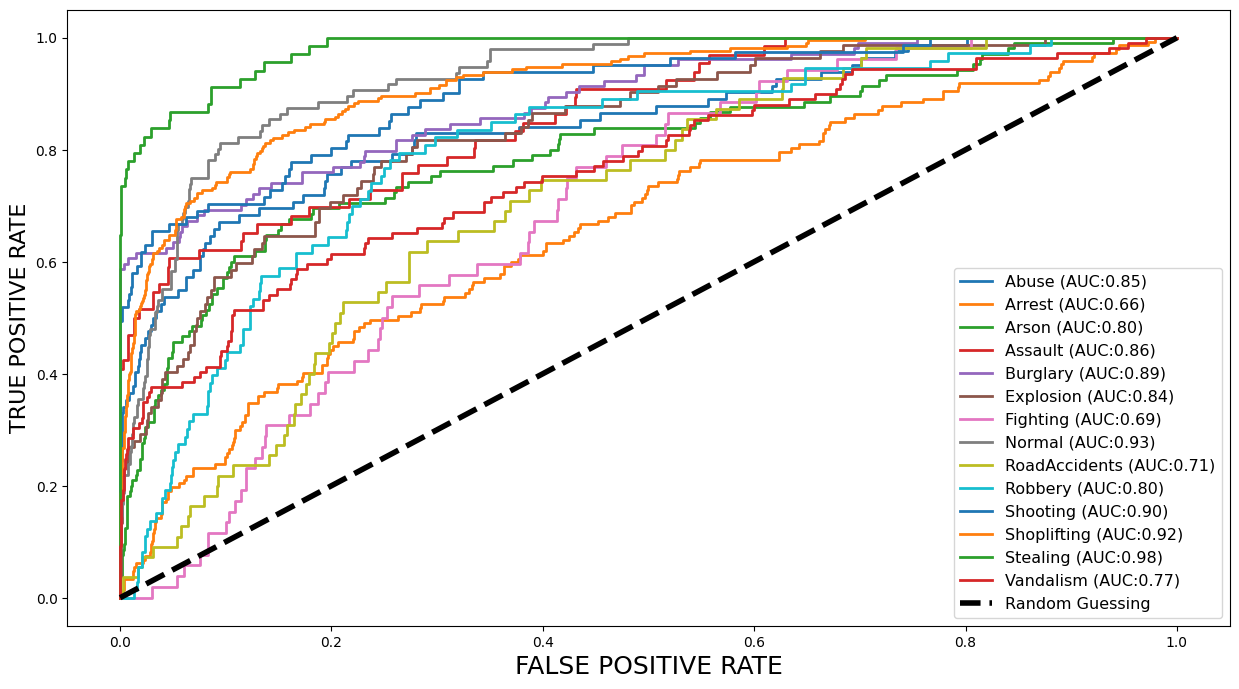

In [ ]:
  import os
  import tensorflow as tf
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  import matplotlib.pyplot as plt
  import seaborn as sns
  from sklearn.metrics import confusion_matrix
  import plotly.express as px
  from sklearn.preprocessing import LabelBinarizer
  from sklearn.metrics import roc_curve, auc, roc_auc_score

  # Set directories for the dataset
  train_dir = "/kaggle/input/custom-dataset/train_dataset"
  test_dir = "/kaggle/input/custom-dataset/test_dataset"

  # Hyperparameters
  IMG_HEIGHT = 64
  IMG_WIDTH = 64
  BATCH_SIZE = 64
  EPOCHS = 26  # Increased to allow proper training
  LR = 0.00003
  NUM_CLASSES = 14  # Number of classes

  # Dynamically extract class labels from the dataset
  CLASS_LABELS = list(train_generator.class_indices.keys())

  # Data generators
  preprocess_fun = tf.keras.applications.densenet.preprocess_input
  train_datagen = ImageDataGenerator(horizontal_flip=True,
                                    rescale=1.0/255,
                                    preprocessing_function=preprocess_fun)

  test_datagen = ImageDataGenerator(rescale=1.0/255,
                                    preprocessing_function=preprocess_fun)

  train_generator = train_datagen.flow_from_directory(train_dir,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      class_mode="categorical")
  test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    class_mode="categorical")

  # Model definition and compilation
  def feature_extractor(inputs):
      return tf.keras.applications.DenseNet121(include_top=False,
                                              weights="imagenet",
                                              input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))(inputs)

  def classifier(inputs):

      x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
      x = tf.keras.layers.Dense(256, activation="relu")(x)
      x = tf.keras.layers.Dropout(0.3)(x)
      x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

      return x

  def define_model():
      inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
      x = feature_extractor(inputs)
      outputs = classifier(x)
      model = tf.keras.Model(inputs, outputs)
      model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LR), loss="categorical_crossentropy", metrics=["accuracy"])
      return model

  model = define_model()

  # Train the model
  model.fit(train_generator, validation_data=test_generator, epochs=EPOCHS)

  # Predictions
  preds = model.predict(test_generator)
  y_pred = preds.argmax(axis=1)
  y_test = test_generator.classes

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(10, 7))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
              xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
  plt.xlabel("Predicted Classes")
  plt.ylabel("True Classes")
  plt.title("Confusion Matrix")
  plt.show()

  # ROC Curve Plotting
  fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))

  def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
      lb = LabelBinarizer()
      lb.fit(y_test)
      y_test = lb.transform(y_test)
      for (idx, c_label) in enumerate(CLASS_LABELS):
          fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), y_pred[:, idx])
          c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
      c_ax.plot(fpr, fpr, 'black', linestyle='dashed', lw=4, label='Random Guessing')
      return roc_auc_score(y_test, y_pred, average=average)

  # Calculate ROC AUC score
  print('ROC AUC score:', multiclass_roc_auc_score(y_test, preds, average="micro"))

  # Customize and show ROC plot
  plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
  plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
  plt.legend(fontsize=11.5)
  plt.show()


##Train Data Distribution

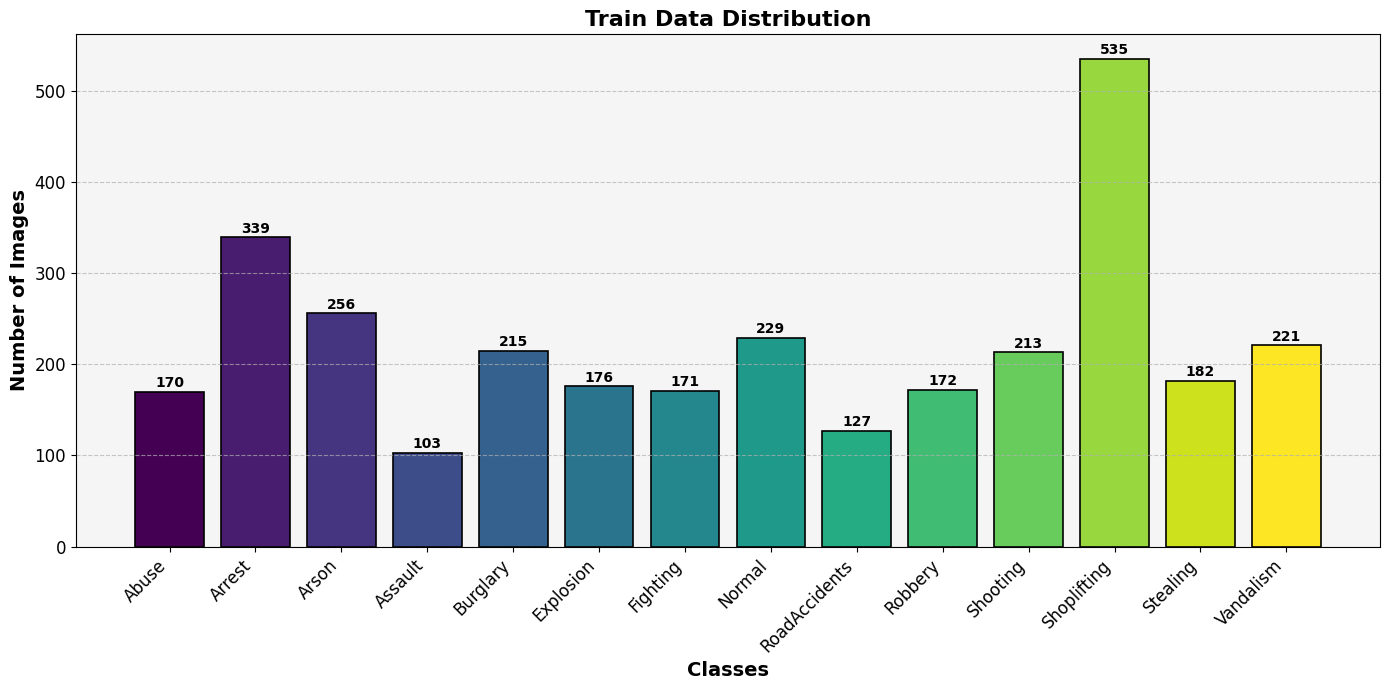

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming CLASS_LABELS and train_generator are already defined
# Example CLASS_LABELS for reference
CLASS_LABELS = ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion',
                'Fighting', "Normal", 'RoadAccidents', 'Robbery', 'Shooting',
                'Shoplifting', 'Stealing', 'Vandalism']

# Calculate the number of images per class
class_counts = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)]

# Define a color palette for the bars
colors = plt.cm.viridis(np.linspace(0, 1, len(CLASS_LABELS)))

# Plotting with Matplotlib
plt.figure(figsize=(14, 7))
bars = plt.bar(CLASS_LABELS, class_counts, color=colors, edgecolor="black", linewidth=1.2)

# Add labels on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(bar.get_height()), ha='center', fontsize=10, fontweight='bold')

# Add labels and title
plt.xlabel("Classes", fontsize=14, fontweight="bold")
plt.ylabel("Number of Images", fontsize=14, fontweight="bold")
plt.title("Train Data Distribution", fontsize=16, fontweight="bold")

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a background style
plt.gca().set_facecolor("whitesmoke")
plt.tight_layout()

# Show the plot
plt.show()

## Test Data Distribution

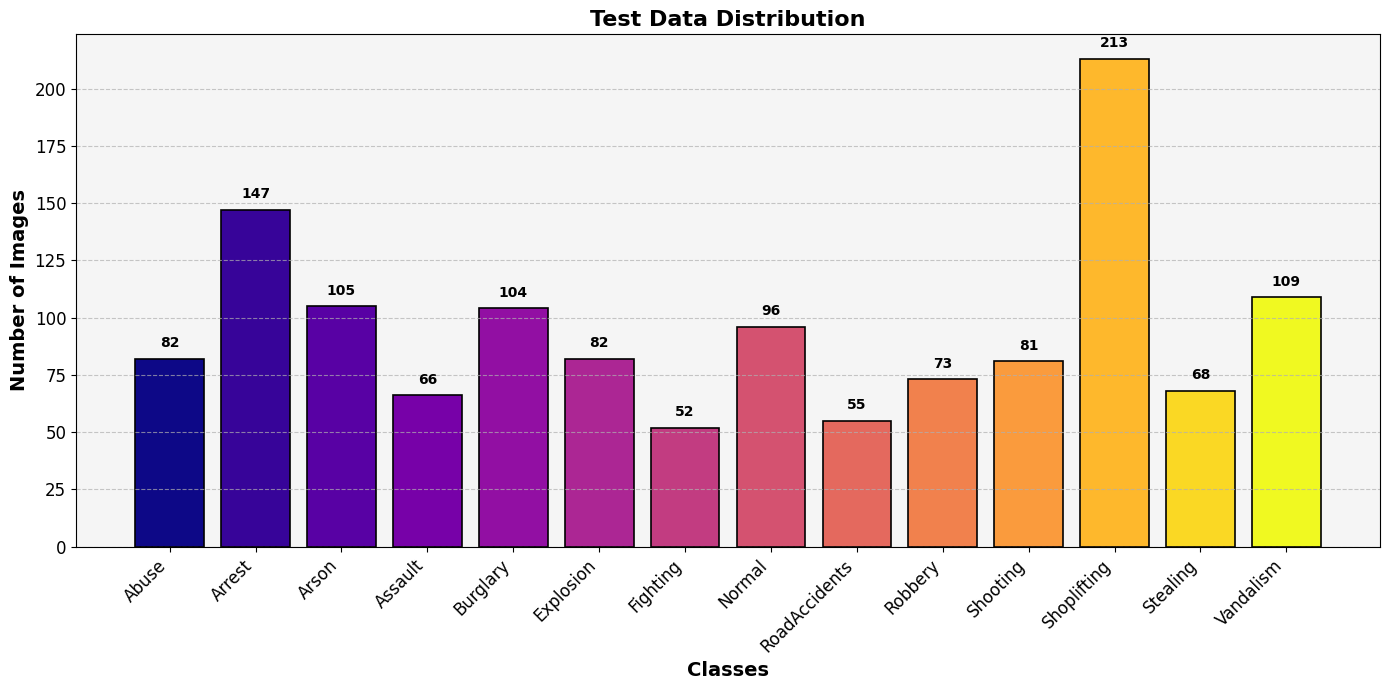

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming CLASS_LABELS and test_generator are already defined
# Example CLASS_LABELS for reference
CLASS_LABELS = ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion',
                'Fighting', "Normal", 'RoadAccidents', 'Robbery', 'Shooting',
                'Shoplifting', 'Stealing', 'Vandalism']

# Calculate the number of images per class for test data
test_class_counts = [list(test_generator.classes).count(i) for i in np.unique(test_generator.classes)]

# Define a color palette for the bars
colors = plt.cm.plasma(np.linspace(0, 1, len(CLASS_LABELS)))

# Plotting with Matplotlib
plt.figure(figsize=(14, 7))
bars = plt.bar(CLASS_LABELS, test_class_counts, color=colors, edgecolor="black", linewidth=1.2)

# Add labels on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(bar.get_height()), ha='center', fontsize=10, fontweight='bold')

# Add labels and title
plt.xlabel("Classes", fontsize=14, fontweight="bold")
plt.ylabel("Number of Images", fontsize=14, fontweight="bold")
plt.title("Test Data Distribution", fontsize=16, fontweight="bold")

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a background style
plt.gca().set_facecolor("whitesmoke")
plt.tight_layout()

# Show the plot
plt.show()

## Multiclass ROC Curve

ROC AUC score: 0.8363467100256511


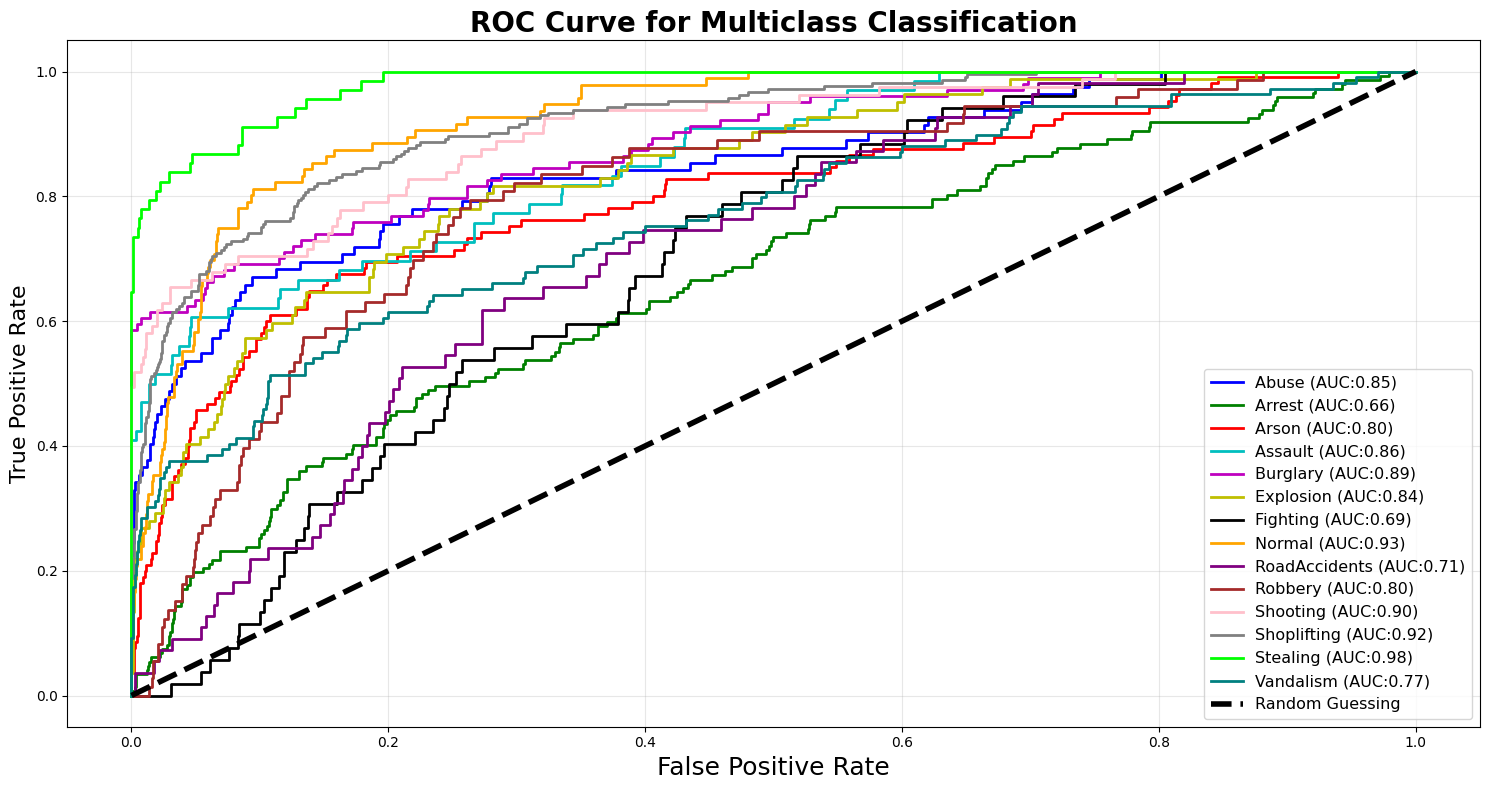

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

# Define your 14 unique colors for the classes
colors = [
    'b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray', 'lime', 'teal'
]

# Assuming y_test, preds, and CLASS_LABELS are already defined
fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)

    for idx, c_label in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), y_pred[:, idx])
        # Use predefined colors for each class
        c_ax.plot(
            fpr, tpr,
            lw=2,
            color=colors[idx],  # Apply unique color
            label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr))
        )

    # Add random guessing line (dashed)
    c_ax.plot(fpr, fpr, 'black', linestyle='dashed', lw=4, label='Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# Calculate ROC AUC score and plot curves
print('ROC AUC score:', multiclass_roc_auc_score(y_test, preds, average="micro"))

# Customize the ROC curve plot
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve for Multiclass Classification', fontsize=20, fontweight='bold')
plt.legend(fontsize=11.5, loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()